In [1]:
import os
import sys
from pathlib import  Path

import zipfile
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import  train_test_split

import tensorflow
import tensorflow as tf
from tensorflow.keras import  layers, callbacks
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError,Huber,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adagrad, RMSprop, Adam

In [2]:
def download_zip_file(url:str, save_path:Path):
    response = requests.get(url)
    
    fileDir,fileName = os.path.split(save_path)
    
    os.makedirs(fileDir, exist_ok=True)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Download successful. File saved at {save_path}")
    else:
        print(f"Error {response.status_code}: Unable to download the file.")


def extract_zip_file(zip_file_path, extract_path):
    
    fileDir, fileName = os.path.split(extract_path)
    os.makedirs(fileDir, exist_ok=True)
    
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extraction successful. Files extracted to {extract_path}")

In [5]:
url = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/60891/6622892/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1701103235&Signature=g6LfrD5gRAw3rsgZROiLNjELdDyBNeCtgzpbVquOBbRTqtnUh8Ky9V5ARgXd2f8ozCX%2FSgCIc9ir5kQJvhaigqhWPR%2FLVzo2QmHlsdwuy0PFbq5u2%2B7VRmZUNhFn320D2WOlOu2e7PgF213GPQAmM2pg%2BAB%2BzGO6Obc3ayYi8oVdoxDcGGMQibAgrFpzWUNt44NedopEb8pmRjMJiCnPCoFqGklxcj1f85NzKMvYuicCxrw0aEyY4endqrIdYWJMlFhB540p3jCzVK91s5RB7C309KAHCFABGNmydyfBRezqGHw1F2LQn4%2BMCYRNe%2Fwv1BrG01fkoPumUnfaE%2F%2FkFQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dplayground-series-s3e24.zip"

zip_file_path = Path('data/classification/smoker/smoker.zip')
extract_path = Path('data/classification/smoker/')

In [6]:
download_zip_file(url,zip_file_path)
extract_zip_file(zip_file_path,extract_path)

Download successful. File saved at data\classification\smoker\smoker.zip
Extraction successful. Files extracted to data\classification\smoker


In [7]:
os.listdir(extract_path)

['sample_submission.csv', 'smoker.zip', 'test.csv', 'train.csv']

In [8]:
df = pd.read_csv('data/classification/smoker/train.csv')
df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [10]:
X = df.iloc[:,1:-1]
y = df.iloc[:, -1]

In [11]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [51]:
X_train = X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(X_train.shape)
print(y_train.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(36).prefetch(tf.data.AUTOTUNE)

(127404, 22)
(127404,)


In [52]:
for x_batch, y_batch in train_dataset.take(1):
    print("Input shape:", x_batch.shape)
    print("Output shape:", y_batch.shape)

Input shape: (36, 22)
Output shape: (36,)


In [55]:
X_val = X[int(DATASET_SIZE*TRAIN_RATIO)
              :int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO)
              :int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
print(X_val.shape)
print(y_val.shape)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = train_dataset.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(2).prefetch(tf.data.AUTOTUNE)

(15926, 22)
(15926,)


In [56]:
X_test = X[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
y_test = y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
print(X_test.shape)
print(y_test.shape)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = train_dataset.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(2).prefetch(tf.data.AUTOTUNE)

(15926, 22)
(15926,)


In [98]:
normalizer = Normalization()
normalizer.adapt(X_train)

early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

In [99]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(22,)),
    normalizer,
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid"),
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 22)               45        
 ion)                                                            
                                                                 
 dense_20 (Dense)            (None, 64)                1472      
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,686
Trainable params: 4,641


Non-trainable params: 45
_________________________________________________________________


In [97]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [106]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy', 'Precision','AUC'])

In [109]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'precision', 'auc', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_auc'])

In [110]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=10,
    verbose=0)

loss = np.mean(history.history['loss'])
valLoss = np.mean(history.history['val_loss'])

acc = np.mean(history.history['binary_accuracy'])
valAcc = np.mean(history.history['val_binary_accuracy'])

auc = np.mean(history.history['auc'])
valAUC = np.mean(history.history['val_auc'])

print(f"BCE  Train  : {loss:.4f}| Val  : {valLoss:.4f}")
print(f"Acc Train   : {acc:.4f} | Val  : {valAcc:.4f}")
print(f"AUC Train   : {auc:.4f} | Val  : {valAUC:.4f}")

BCE  Train  : 0.4379| Val  : 0.4371
Acc Train   : 0.7840 | Val  : 0.7843
AUC Train   : 0.8687 | Val  : 0.8694


MAE  Train  : 17588.7341 | Val  : 23439.9015

RMSE Train  : 23381.5194 | Val  : 29499.5435

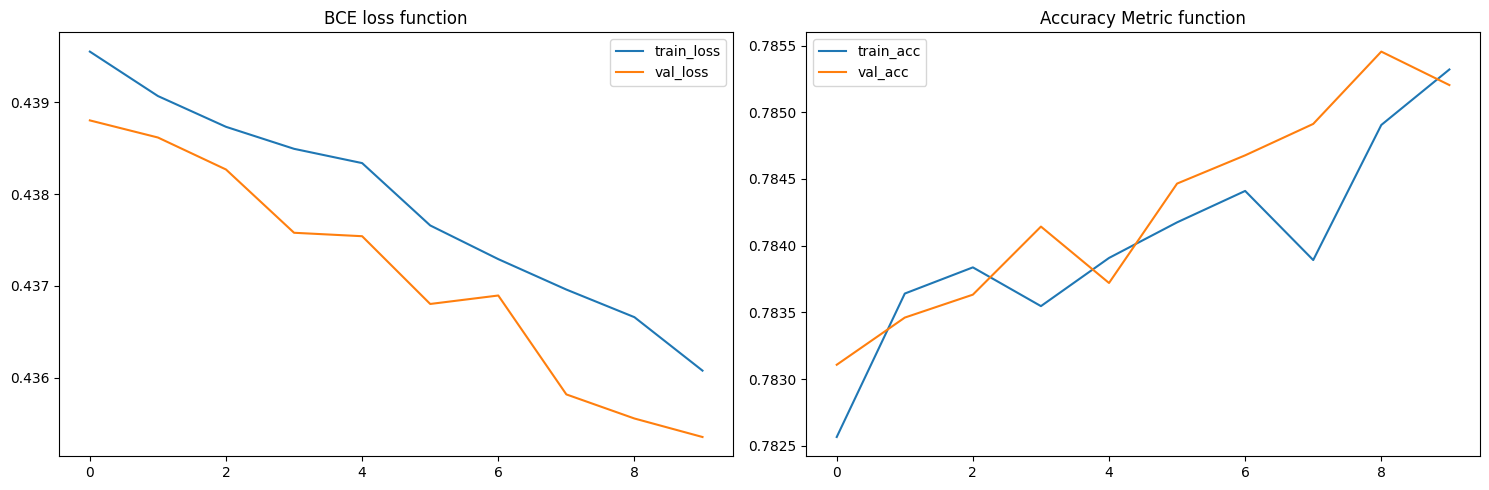

In [112]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(history.history['loss'], label="train_loss")
ax[0].plot(history.history['val_loss'], label="val_loss")
ax[0].set_title("BCE loss function")
ax[0].legend()

ax[1].plot(history.history['binary_accuracy'], label="train_acc")
ax[1].plot(history.history['val_binary_accuracy']           , label="val_acc")
ax[1].set_title("Accuracy Metric function")
ax[1].legend()
plt.tight_layout()
plt.show()

In [113]:
hist_eval = model.evaluate(X_test,y_test)

498/498 [==============================] - 2s 2ms/step - loss: 0.4704 - binary_accuracy: 0.7648 - precision: 0.6969 - auc: 0.8485


In [114]:
hist_eval

[0.4704064726829529,
 0.7648499011993408,
 0.6968988180160522,
 0.8484902381896973]

In [115]:
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score,precision_score,recall_score,roc_curve

In [116]:
y_pred = model.predict(X_test)

498/498 [==============================] - 1s 1ms/step


In [117]:
y_pred.squeeze()

array([0.02763649, 0.00788765, 0.86788124, ..., 0.00365404, 0.7159475 ,
       0.03520054], dtype=float32)

In [118]:
def labels_with_thresh(pred_prob, optimal_threshold):
    pred_labels = []
    for i in pred_prob:
        if i > optimal_threshold:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    return pred_labels

# thresholds --> for each thresholds compute fpr and tpr


def optimum_thresh(y_labels, pred_prob):
    fpr, tpr, thresholds = roc_curve(y_labels, pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, fpr, tpr

In [119]:
optimal_threshold, _, _ = optimum_thresh(y_test.ravel(),y_pred.squeeze())

In [120]:
test_labels = y_test.ravel()
pred_labels = labels_with_thresh(y_pred.squeeze(), optimal_threshold)
pred_probs = y_pred.squeeze()

In [121]:
print("Test data Accuracy Score   : {:.3f}".format(
    accuracy_score(test_labels, pred_labels)))
print("Test data Precision Score  : {:.3f}".format(
    precision_score(test_labels, pred_labels)))
print("Test data Recall Score     : {:.3f}".format(
    recall_score(test_labels, pred_labels)))
print("Test data F1 Score         : {:.3f}".format(
    f1_score(test_labels, pred_labels)))
print("Test data ROC_AUC Score    : {:.3f}".format(
    roc_auc_score(test_labels, pred_probs)))

Test data Accuracy Score   : 0.762
Test data Precision Score  : 0.678
Test data Recall Score     : 0.866
Test data F1 Score         : 0.761
Test data ROC_AUC Score    : 0.849
